In [1]:
# Beginning of "prototyping_notebook.ipynb"

This notebook is for prototyping the functions nnd other logic that will be used in the Personal Finance Project.

Create a simple data pipeline that will take a CSV file, clean the data, ensure proper data types then load in MySQl before Phase 2.

Initiate current directory and import the CSV file.

In [2]:
# Import all necessary libraries and module
from pathlib import Path
import pandas as pd
import re # <-- for function removing apostrophes

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Get the current directory
current_directory=Path.cwd()
print(current_directory)

/run/media/joebravo/Extreme SSD/personal_finances_project


Confirmed that I am in the correct dirrectory.

In [18]:
# Navigate to directory containing file I wanted
file_path = Path('data/DEC_2023.csv')

raw_data = pd.read_csv(file_path)
raw_data['date'] = pd.to_datetime(raw_data['date']).dt.date

raw_data.head()

,date,day,description,category,amount
0,2023-12-01,Friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,Friday,Andy's Boy,meds,60.00
2,2023-12-01,Friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,Friday,TicketWeb,entertainment,49.20
4,2023-12-02,Saturday,Lyft,rideshare,6.00


Successfully imported the CSV data file and got a quick snap shot of the data.

In [5]:
raw_data.dtypes

date            object
day             object
description     object
category        object
amount         float64
dtype: object

Use conditonal IF statements to check the data types of each column and then change if it's not the data type I want.

In [28]:
if raw_data.date.dtype != object:
    print("it's not an object dtype")
else:
    print("it's an object data type")

it's an object data type


Convert the day column from object to string for further data processing.

In [29]:
# raw_data['daycolumn'] = df['column'].astype('|S') # which will by default set the length to the max len it encounters

In [6]:
raw_data.tail()

,date,day,description,category,amount
105,2023-12-30,Saturday,Mira Mesa Crown Liquor,drinks,17.99
106,2023-12-30,Saturday,Chevron,groceries,2.79
107,2023-12-30,Saturday,Hyatt House,parking,16.00
108,2023-12-31,sunday,Quick Mart,drinks,12.58
109,2023-12-31,sunday,76 Fuel,groceries,3.32


In [7]:
# Convert 'col1' to lowercase
raw_data['day'] = raw_data['day'].str.lower()
raw_data.head()

,date,day,description,category,amount
0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,2023-12-02,saturday,Lyft,rideshare,6.00


In [32]:
raw_data['day'].unique()

array(['friday', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday',
       'thursday'], dtype=object)

Want to buddle the above into a function to use in my DAG for this project.

In [19]:
def process_day_col(df):
    """Helper function to make all strings in day column lower case."""
    df['day'] = df['day'].str.lower()
    return df

In [20]:
# Test the above function
input_df = raw_data
input_df.head()

processed_df = process_day_col(input_df)

Function that reads a CSV file using Pandas, then creates SQL insert queries to insert data into a PostgreSQL table.

In [21]:
processed_df.columns

Index(['date', 'day', 'description', 'category', 'amount'], dtype='object')

In [39]:
def generate_insert_queries(filepath):
    # Read the CSV file
    df = pd.read_csv(filepath)
    # Creae a list of SQL insert queries
    insert_queries = []
    for idx, row in df.iterrows():
        insert_query = f"INSERT INTO sample_table (date, 'day', 'description', 'category', amount) VALUES ({row['date']}, {row['day']}, {row['description']}, {row['category']}, {row['amount']});"
        insert_queries.append(insert_query)
    # Save queries to a file for the SQL Operator to execute
    with open('./data/insert_queries.sql', 'w') as f:
        for query in insert_queries:
            f.write(f"{query}\n")


In [40]:
generate_insert_queries(file_path)

Create and test a function that removes apostrophes from strings in a Pandas column.

In [5]:
def remove_apostrophe(df, col):
    df[col] = df[col].astype(str).apply(lambda x: re.sub(r"'", "", x))
    return df

# Create testing data
data = {'text': ["this's a string", "Otter's Den", "TGIFridays", "Applebee's"]}
df = pd.DataFrame(data)
df = remove_apostrophe(df, 'text')

# Test the function
print(df)


             text
0  thiss a string
1      Otters Den
2      TGIFridays
3       Applebees


Following will be to used to connect to the correct table in PostgreSQL and run through plotting functions to create the Shiny app.

In [31]:
import psycopg2
import yaml
from pathlib import Path
import os
# # Get the path of the current script
# script_path = Path(__file__).resolve()
# # Get the directory containing the script
# script_directory = script_path.parent
# # Change the current working directory to the script's directory
# os.chdir(script_directory)

# Read the config file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Create a connection to db server
conn = psycopg2.connect(
    f"host={config["server"]["host"]} \
    dbname={config["database"]["name"]} \
    user={config["database"]["user"]} \
    password={config["database"]["password"]} \
    "
)

# To issue queries to the server
cur = conn.cursor()

# Execute commands on the postgres db
# cur.execute("""SELECT category, COUNT(*) FROM dec_2023 GROUP BY category HAVING COUNT(category) > 5 ORDER BY COUNT(*) desc;""")
cur.execute("""SELECT * FROM dec_2023;""")

# Collect all rows from query's result and return as a list
allresults = cur.fetchall()

print(allresults)

[(datetime.date(2023, 12, 1), 'Friday', 'Tlatoani Barbershop', 'haircut', '60.0'), (datetime.date(2023, 12, 1), 'Friday', 'Andys Boy', 'meds', '60.0'), (datetime.date(2023, 12, 1), 'Friday', 'Nob Hill Foods', 'drinks', '13.43'), (datetime.date(2023, 12, 1), 'Friday', 'TicketWeb', 'entertainment', '49.2'), (datetime.date(2023, 12, 2), 'Saturday', 'Lyft', 'rideshare', '6.0'), (datetime.date(2023, 12, 2), 'Saturday', 'street vendor', 'eating out', '5.0'), (datetime.date(2023, 12, 2), 'Saturday', 'Hilton Hotel', 'hotels', '259.66'), (datetime.date(2023, 12, 2), 'Saturday', 'Mezcal', 'restaurant', '73.74'), (datetime.date(2023, 12, 2), 'Saturday', 'The Cheesecake Factory', 'restaurant', '108.16'), (datetime.date(2023, 12, 2), 'Saturday', 'Beverages & More', 'miscellaneous', '26.88'), (datetime.date(2023, 12, 2), 'Saturday', 'Lyft', 'rideshare', '15.85'), (datetime.date(2023, 12, 2), 'Saturday', 'Lyft', 'rideshare', '10.74'), (datetime.date(2023, 12, 2), 'Saturday', 'San Jose Improv', 'resta

In [32]:
type(allresults)

list

In [33]:
# Get column names from the cursor description
column_names = [description[0] for description in cur.description]

In [34]:
# Create a Pandas DataFrame
df = pd.DataFrame(allresults, columns=column_names)

In [28]:
# Close the connection
conn.close()

In [35]:
# Now you can work with the DataFrame 'df'
print(df)

           date        day                  description         category  \
0    2023-12-01     Friday          Tlatoani Barbershop          haircut   
1    2023-12-01     Friday                    Andys Boy             meds   
2    2023-12-01     Friday               Nob Hill Foods           drinks   
3    2023-12-01     Friday                    TicketWeb    entertainment   
4    2023-12-02   Saturday                         Lyft        rideshare   
5    2023-12-02   Saturday                street vendor       eating out   
6    2023-12-02   Saturday                 Hilton Hotel           hotels   
7    2023-12-02   Saturday                       Mezcal       restaurant   
8    2023-12-02   Saturday       The Cheesecake Factory       restaurant   
9    2023-12-02   Saturday             Beverages & More    miscellaneous   
10   2023-12-02   Saturday                         Lyft        rideshare   
11   2023-12-02   Saturday                         Lyft        rideshare   
12   2023-12

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.set_ylabel('dollars ($)')
bplot = ax.boxplot(fruit_weights,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

In [37]:
df.columns

Index(['date', 'day', 'description', 'category', 'amount'], dtype='object')

In [45]:
df['amount'] = df['amount'].astype(float)

<Axes: >

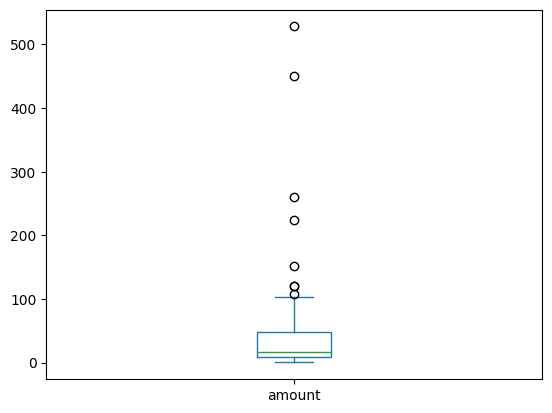

In [48]:
df.plot(
    kind = 'box',
    x = 'category',
    y = 'amount'
)

Want to add an index column to the dataframe. The postgres table has index column "txn_id" that is unique to each transaction and is the primary serial key for each table.

In [22]:
processed_df.head(25)

,date,day,description,category,amount
0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,2023-12-02,saturday,Lyft,rideshare,6.00
5,2023-12-02,saturday,street vendor,eating out,5.00
6,2023-12-02,saturday,Hilton Hotel,hotels,259.66
7,2023-12-02,saturday,Mezcal,restaurant,73.74
8,2023-12-02,saturday,The Cheesecake Factory,restaurant,108.16
9,2023-12-02,saturday,Beverages & More,miscellaneous,26.88


In [23]:
processed_df.insert(0, 'txn_id', range(len(processed_df)))
print(processed_df)

     txn_id        date        day                   description  \
0         0  2023-12-01     friday           Tlatoani Barbershop   
1         1  2023-12-01     friday                    Andy's Boy   
2         2  2023-12-01     friday                Nob Hill Foods   
3         3  2023-12-01     friday                     TicketWeb   
4         4  2023-12-02   saturday                          Lyft   
5         5  2023-12-02   saturday                 street vendor   
6         6  2023-12-02   saturday                  Hilton Hotel   
7         7  2023-12-02   saturday                        Mezcal   
8         8  2023-12-02   saturday        The Cheesecake Factory   
9         9  2023-12-02   saturday              Beverages & More   
10       10  2023-12-02   saturday                          Lyft   
11       11  2023-12-02   saturday                          Lyft   
12       12  2023-12-02   saturday               San Jose Improv   
13       13  2023-12-02   saturday              

In [14]:
# End of "prototyping_notebook.ipynb"